In [7]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

In [ ]:
struct Grid
    x::Vector
    y::Vector
    xc::Vector
    yc::Vector
    nx::Int
    ny::Int
    W::Float64
    H::Float64
    dx::Float64
    dy::Float64
    function Grid(W::Float64,H::Float64,nx::Int,ny::Int)
        dx = W/(nx-1)
        dy = H/(ny-1)
        new(LinRange(0,W,nx),LinRange(0,H,ny),
            LinRange(0-dx/2,W+dx/2,nx+1),LinRange(0-dy/2,H+dy/2,ny+1),
            nx,ny,W,H,W/(nx-1),H/(ny-1))
    end
end

struct BoundaryConditions
    # The intent here is that each boundary gets a flag
    # 0 = Free-slip
    # 1 = No-slip
    # other possibilities?
    top::Int
    bottom::Int
    left::Int
    right::Int
end

function initial_conditions(grid::Grid)
    # Setup the initial density structure
    rho = zeros(grid.ny,grid.nx)
    etaS = ones(grid.ny,grid.nx)
    etaN = ones(grid.ny,grid.nx)
    for i in 1:grid.ny
        for j in 1:grid.nx
            if grid.x[j] < grid.W/2.
                rho[i,j] = 3200.
                etaS[i,j] = 1.0e21
            else
                rho[i,j] = 3300.
                etaS[i,j] = 1.0e23
            end
            if grid.xc[j] < grid.W/2.
                etaN[i,j] = 1.0e21
            else
                etaN[i,j] = 1.0e23
            end
        end
    end
    
    return rho, etaS, etaN
end

function initial_conditions_updown(grid::Grid)
    # Setup the initial density structure
    rho = zeros(grid.ny,grid.nx)
    etaS = ones(grid.ny,grid.nx)
    etaN = ones(grid.ny,grid.nx)
    for i in 1:grid.ny
        for j in 1:grid.nx
            if grid.y[i] < grid.H/2.
                rho[i,j] = 3200.
                etaS[i,j] = 1.0e21
            else
                rho[i,j] = 3300.
                etaS[i,j] = 1.0e21
            end
            if grid.yc[i] < grid.H/2.
                etaN[i,j] = 1.0e21
            else
                etaN[i,j] = 1.0e21
            end
        end
    end
    
    return rho, etaS, etaN
end


node_index(i::Int,j::Int,ny::Int) = ny*(j-1)+i
vxdof(i::Int,j::Int,ny::Int) = 3*(node_index(i,j,ny)-1)+1
vydof(i::Int,j::Int,ny::Int) = 3*(node_index(i,j,ny)-1)+2
pdof( i::Int,j::Int,ny::Int) = 3*(node_index(i,j,ny)-1)+3


function form_stokes(grid::Grid,eta_s::Matrix,eta_n::Matrix,bc::BoundaryConditions,gx::Float64,gy::Float64)
    k::Int = 1 # index into dof arrays
    nx = grid.nx
    ny = grid.ny
    nn = nx*ny
    nnz = 2*11*nn + 5*nn # total number of nonzeros in matrix (not including BCs)
    row_index = zeros(Int64,nnz) # up to 5 nonzeros per row
    col_index = zeros(Int64,nnz) 
    value = zeros(Float64, nnz)
    kcont = 2*eta_s[1,1]/(grid.dx+grid.dy)# scaling factor for continuity equation
    kcont = 1e20/(grid.dx+grid.dy)*2
    kbond = 1.# scaling factor for dirichlet bc equations.

    R=zeros(3*nn,1)
    
    # loop over j
    for j in 1:nx
        # loop over i
        for i in 1:ny
            dxp = j<nx ? grid.x[j+1] - grid.x[j]   : grid.x[j]   - grid.x[j-1]
            dxm = j>1  ? grid.x[j]   - grid.x[j-1] : grid.x[j+1] - grid.x[j]
            dxc = 0.5*(dxp+dxm)
            dyp = i<ny ? grid.yc[i+1]- grid.yc[i]   : grid.yc[i]   -grid.yc[i-1]
            dym = i>1  ? grid.yc[i]  - grid.yc[i-1] : grid.yc[i+1] -grid.yc[i]
            dyc = 0.5*(dyp+dym)

            # discretize the x-stokes - note that numbering in comments refers to Gerya Figure 7.18a
            # and equation 7.22
            this_row = vxdof(i,j,ny)
            # Boundary cases first...            
            if j==1 || j == nx # left boundary or right boundary
                # vx = 0
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                R[this_row] = 0.0 *kbond
            elseif i==1
                # dvx/dy = 0 (free slip)
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = -kbond
                k+=1
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j,ny)
                value[k] = kbond
                k+=1                
                R[this_row] = 0.0*kbond
            else
                # vx1
                row_index[k] = this_row
                col_index[k] = vxdof(i,j-1,ny)
                value[k] = 2*eta_n[i,j]/dxm/dxc
                k+=1
                # vx2
                row_index[k] = this_row
                col_index[k] = vxdof(i-1,j,ny)
                value[k] = eta_s[i-1,j]/dym/dyc
                k+=1
                # vx3
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = -2*eta_n[i,j+1]/dxp/dxc -2*eta_n[i,j]/dxm/dxc - eta_s[i,j]/dyp/dyc - eta_s[i-1,j]/dym/dyc
                if i == ny #vx4
                    # if i == nx, dvx/dy = 0 -> vx3 == vx4 (see Gerya fig 7.18a)
                    value[k] += eta_s[i,j]/dyp/dyc
                    k+=1
                else
                    k+=1
                    # vx4

                    # enforce dvx/dy = 0 (free slip)                
                    row_index[k] = this_row
                    col_index[k] = vxdof(i+1,j,ny)
                    value[k] = eta_s[i,j]/dyp/dyc
                    k+=1
                end

                # vx5
                row_index[k] = this_row
                col_index[k] = vxdof(i,j+1,ny)
                value[k] = 2*eta_n[i,j+1]/dxp/dxc
                k+=1
                # vy1
                row_index[k] = this_row
                col_index[k] = vydof(i-1,j,ny)
                value[k] = eta_s[i-1,j]/dxc/dyc
                k+=1
                # vy2
                row_index[k] = this_row
                col_index[k] = vydof(i,j,ny)
                value[k] = -eta_s[i,j]/dxc/dyc
                k+=1
                # vy3
                row_index[k] = this_row
                col_index[k] = vydof(i-1,j+1,ny)
                value[k] = -eta_s[i-1,j]/dxc/dyc
                k+=1
                # vy4
                row_index[k] = this_row
                col_index[k] = vydof(i,j+1,ny)
                value[k] = eta_s[i,j]/dxc/dyc
                k+=1
                # P1
                row_index[k] = this_row
                col_index[k] = pdof(i,j,ny)
                value[k] = kcont/dxc
                k+=1
                # P2
                row_index[k] = this_row
                col_index[k] = pdof(i,j+1,ny)
                value[k] = -kcont/dxc
                k+=1

                R[this_row] = -gx*(rho[i-1,j]+rho[i,j])/2.
            end
            # END X-STOKES
            
            # BEGIN Y-STOKES
            dxp = j < nx ? grid.xc[j+1] - grid.xc[j]   : grid.xc[j]  -grid.xc[j-1]
            dxm = j > 1  ? grid.xc[j]   - grid.xc[j-1] : grid.xc[j+1]-grid.xc[j]
            dxc = j > 1  ? grid.x[j]    - grid.x[j-1]  : grid.x[j+1] - grid.x[j]
            dyp = i < ny ? grid.y[i+1]  - grid.y[i]    : grid.y[i]   - grid.y[i-1]
            dym = i > 1  ? grid.y[i]    - grid.y[i-1]  : grid.y[i+1] - grid.y[i]
            dyc = i < ny ? grid.yc[i+1] - grid.yc[i]   : grid.yc[i]  - grid.yc[i-1]            
            
            this_row = vydof(i,j,ny)
            if i==1 || i == ny
                # top row / bottom row
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                R[this_row] = 0.0*kbond
            elseif j==1
                # left boundary - free slip
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = kbond
                k+=1
                row_index[k] = this_row
                col_index[k] = vydof(i,j+1,ny)
                value[k] = -kbond
                k+=1
                R[this_row] = 0.0*kbond
            else            
                #vy1
                row_index[k] = this_row
                col_index[k] = vydof(i,j-1,ny)
                value[k] = eta_s[i,j-1]/dxm/dxc
                k+=1
                #vy2
                row_index[k] = this_row
                col_index[k] = vydof(i-1,j,ny)
                value[k] = 2*eta_n[i,j]/dym/dyc
                k+=1
                #vy3
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = -2*eta_n[i+1,j]/dyp/dyc -2*eta_n[i,j]/dym/dyc - eta_s[i,j]/dxp/dxc - eta_s[i,j-1]/dxm/dxc
                if j == nx
                   # free slip - vx5 = vx3.
                   value[k] += eta_s[i,j]/dxp/dxc
                end
                k+=1
                
                #vy4
                row_index[k] = this_row
                col_index[k] = vydof(i+1,j,ny)
                value[k] = 2*eta_n[i+1,j]/dyp/dyc
                k+=1
                #vy5
                if j<nx
                    row_index[k] = this_row
                    col_index[k] = vydof(i,j+1,ny)
                    value[k] = eta_s[i,j]/dxp/dxc
                    k+=1
                end
                #vx1
                row_index[k] = this_row
                col_index[k] = vxdof(i,j-1,ny)
                value[k] = eta_s[i,j-1]/dxc/dyc
                k+=1
                #vx2
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j-1,ny)
                value[k] = -eta_s[i+1,j-1]/dxc/dyc
                k+=1
                #vx3
                row_index[k] = this_row
                col_index[k] = vxdof(i,j,ny)
                value[k] = -eta_s[i,j]/dxc/dyc
                k+=1
                #vx4
                row_index[k] = this_row
                col_index[k] = vxdof(i+1,j,ny)
                value[k] = eta_s[i+1,j]/dxc/dyc
                k+=1
                #P1
                row_index[k] = this_row
                col_index[k] = pdof(i,j,ny)
                value[k] = kcont/dyc
                k+=1
                #P2
                row_index[k] = this_row
                col_index[k] = pdof(i+1,j,ny)
                value[k] = -kcont/dyc
                k+=1

                R[this_row] = -gy*(rho[i,j-1]+rho[i,j])/2.
            end
            # END Y-STOKES
            
            # discretize the continuity equation
            # dvx/dx + dvy/dy = 0
            this_row = pdof(i,j,ny)
            if i==1 || j == 1 || (i==2 && j == 2)
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] =  kbond
                k+=1  
                R[this_row] = 0.0
            else
                dxm = grid.x[j] - grid.x[j-1]
                dym = grid.y[i] - grid.y[i-1]
                
                row_index[k] = this_row
                col_index[k] = vxdof(i,j,ny)
                value[k] =  kcont/dxm
                k+=1

                row_index[k] = this_row
                col_index[k] = vxdof(i,j-1,ny)
                value[k] = -kcont/dxm
                k+=1

                row_index[k] = this_row
                col_index[k] = vydof(i,j,ny)
                value[k] =  kcont/dym
                k+=1

                row_index[k] = this_row
                col_index[k] = vydof(i-1,j,ny)
                value[k] = -kcont/dym
                k+=1
                
                row_index[k] = this_row
                col_index[k] = this_row
                value[k] = 0.0
                k+=1

                R[this_row] = 0.0
            end
            # END CONTINUITY
            
        end
    end
    @views row_index = row_index[1:(k-1)]
    @views col_index = col_index[1:(k-1)]
    @views value = value[1:(k-1)]

    L = sparse(row_index,col_index,value)
    return L,R    
end

function unpack(solution, grid::Grid)
    P = zeros(Float64,(grid.ny,grid.nx))
    vx = zeros(Float64,(grid.ny,grid.nx))
    vy = zeros(Float64,(grid.ny,grid.nx))
    ny = grid.ny
     for j in 1:grid.nx
        for i in 1:grid.ny                
            vx[i,j] = solution[vxdof(i,j,grid.ny)]
            vy[i,j] = solution[vydof(i,j,grid.ny)]
            P[i,j]  = solution[pdof(i,j,grid.ny)]            
        end
    end
    return vx,vy,P
end

In [11]:
# Set up the grid
nx = 51
ny = 61
W = 1e5
H = 1.5e5
gy = -10.0
gx = 0.0
grid = Grid(W,H,nx,ny)
rho,eta_s,eta_n = initial_conditions(grid)
bc = BoundaryConditions(0,0,0,0)
@time L,R = form_stokes(grid,eta_s,eta_n,bc,gx,gy)
@time solution = L\R
@time vx,vy,P = unpack(solution,grid)

  0.023697 seconds (518.83 k allocations: 12.573 MiB)
  0.090482 seconds (71 allocations: 23.254 MiB)
  0.000054 seconds (10 allocations: 73.203 KiB)


([0.0 -5.50396293736023e-13 … -3.4688918331789017e-13 0.0; 0.0 -5.50396293736023e-13 … -3.4688918331789017e-13 0.0; … ; 0.0 5.483457299177131e-13 … 3.4547050887811753e-13 0.0; 0.0 5.503962937357265e-13 … 3.468891833178886e-13 0.0], [0.0 0.0 … 0.0 0.0; 6.879953671700466e-13 6.879953671700466e-13 … -4.3344863165848884e-13 -4.336114791473628e-13; … ; 6.879953671696582e-13 6.879953671696582e-13 … -4.334486316584888e-13 -4.3361147914736076e-13; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0826863635806883e-9 1.0838543719173128e-9; … ; 0.0 -1.0443767140427092e-7 … -1.0546599736165832e-7 -1.054671561327484e-7; 0.0 -1.0623772674780512e-7 … -1.0732041311138585e-7 -1.0732158111972246e-7])

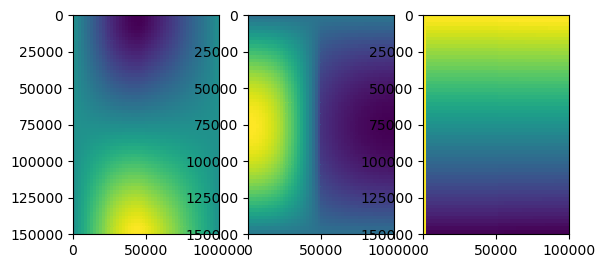

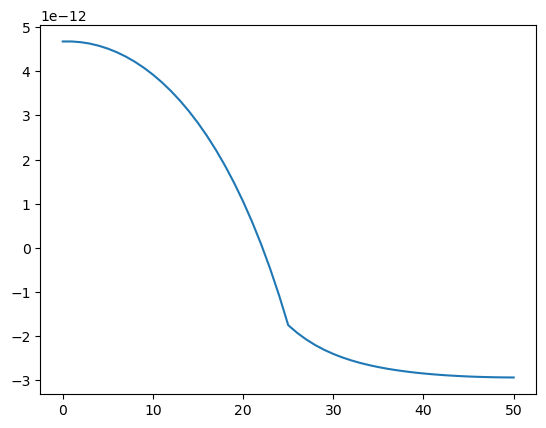

In [12]:
figure()
subplot(1,3,1)
pcolor(grid.x,grid.y,vx)
gca().set_aspect("equal")
gca().invert_yaxis()

subplot(1,3,2)
pcolor(grid.x,grid.y,vy)
gca().set_aspect("equal")
gca().invert_yaxis()

subplot(1,3,3)
pcolor(grid.x,grid.y,P)
gca().set_aspect("equal")
gca().invert_yaxis()
show()

figure()
plot(vy[8,: ])
show()

In [5]:
# Attempt a faster solution using GMRES preconditioned with algebraic multigrid
function solve_gmres(L,R)
    ml = ruge_stuben(L);
    p = aspreconditioner(ml);
    return gmres(L, R; Pl=p, restart = 200)
end
    
@time s = solve_gmres(L,R);

LoadError: InterruptException:

In [12]:
L

753003×753003 SparseMatrixCSC{Float64, Int64} with 6742999 stored entries:
⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠻⣦

In [4]:
ENV

Base.EnvDict with 25 entries:
  "USER"                          => "maxrudolph"
  "JUPYTERHUB_HOST"               => ""
  "JUPYTERHUB_USER"               => "maxrudolph"
  "HOME"                          => "/home/maxrudolph"
  "JUPYTERHUB_OAUTH_CALLBACK_URL" => "/user/maxrudolph/oauth_callback"
  "JUPYTERHUB_API_URL"            => "http://127.0.0.1:8081/hub/api"
  "JUPYTERHUB_CLIENT_ID"          => "jupyterhub-user-maxrudolph"
  "PATH"                          => "/opt/julia-1.7.1/bin:/opt/conda/bin:/usr/…
  "JUPYTERHUB_ACTIVITY_URL"       => "http://127.0.0.1:8081/hub/api/users/maxru…
  "LANG"                          => "C.UTF-8"
  "SHELL"                         => "/bin/bash"
  "JUPYTERHUB_SERVICE_PREFIX"     => "/user/maxrudolph/"
  "LC_ALL"                        => "C.UTF-8"
  "JUPYTERHUB_API_TOKEN"          => "e51568eac2444d0788ef0a8e47288d08"
  "PWD"                           => "/home/maxrudolph"
  "JUPYTERHUB_SERVER_NAME"        => ""
  "JUPYTERHUB_BASE_URL"           => "